# Emojify! 

Welcome to the second assignment of Week 2! You're going to use word vector representations to build an Emojifier. 
🤩 💫 🔥

Have you ever wanted to make your text messages more expressive? Your emojifier app will help you do that. 
Rather than writing:
>"Congratulations on the promotion! Let's get coffee and talk. Love you!"   

The emojifier can automatically turn this into:
>"Congratulations on the promotion! 👍  Let's get coffee and talk. ☕️ Love you! ❤️"

You'll implement a model which inputs a sentence (such as "Let's go see the baseball game tonight!") and finds the most appropriate emoji to be used with this sentence (⚾️).

### Using Word Vectors to Improve Emoji Lookups
* In many emoji interfaces, you need to remember that ❤️  is the "heart" symbol rather than the "love" symbol. 
    * In other words, you'll have to remember to type "heart" to find the desired emoji, and typing "love" won't bring up that symbol.
* You can make a more flexible emoji interface by using word vectors!
* When using word vectors, you'll see that even if your training set explicitly relates only a few words to a particular emoji, your algorithm will be able to generalize and associate additional words in the test set to the same emoji.
    * This works even if those additional words don't even appear in the training set. 
    * This allows you to build an accurate classifier mapping from sentences to emojis, even using a small training set. 

### What you'll build:
1. In this exercise, you'll start with a baseline model (Emojifier-V1) using word embeddings.
2. Then you will build a more sophisticated model (Emojifier-V2) that further incorporates an LSTM. 

By the end of this notebook, you'll be able to:

* Create an embedding layer in Keras with pre-trained word vectors
* Explain the advantages and disadvantages of the GloVe algorithm
* Describe how negative sampling learns word vectors more efficiently than other methods
* Build a sentiment classifier using word embeddings
* Build and train a more sophisticated classifier using an LSTM

🏀 👑

👆 😎

(^^^ Emoji for "skills") 

## Table of Contents

- [Packages](#0)
- [1 - Baseline Model: Emojifier-V1](#1)
    - [1.1 - Dataset EMOJISET](#1-1)
    - [1.2 - Overview of the Emojifier-V1](#1-2)
    - [1.3 - Implementing Emojifier-V1](#1-3)
        - [Exercise 1 - sentence_to_avg](#ex-1)
    - [1.4 - Implement the Model](#1-4)
        - [Exercise 2 - model](#ex-2)
    - [1.5 - Examining Test Set Performance](#1-5)
- [2 - Emojifier-V2: Using LSTMs in Keras](#2)
    - [2.1 - Model Overview](#2-1)
    - [2.2 Keras and Mini-batching](#2-2)
    - [2.3 - The Embedding Layer](#2-3)
        - [Exercise 3 - sentences_to_indices](#ex-3)
        - [Exercise 4 - pretrained_embedding_layer](#ex-4)
    - [2.4 - Building the Emojifier-V2](#2-4)
        - [Exercise 5 - Emojify_V2](#ex-5)
    - [2.5 - Train the Model](#2-5)
- [3 - Acknowledgments](#3)

<a name='0'></a>
## Packages

Let's get started! Run the following cell to load the packages you're going to use. 

In [1]:
import numpy as np
from emo_utils import *
import emoji
import matplotlib.pyplot as plt
from test_utils import *

%matplotlib inline


<a name='1'></a>
## 1 - Baseline Model: Emojifier-V1

<a name='1-1'></a>
### 1.1 - Dataset EMOJISET

Let's start by building a simple baseline classifier. 

You have a tiny dataset (X, Y) where:
- X contains 127 sentences (strings).
- Y contains an integer label between 0 and 4 corresponding to an emoji for each sentence.

<img src="images/data_set.png" style="width:700px;height:300px;">
<caption><center><font color='purple'><b>Figure 1</b>: EMOJISET - a classification problem with 5 classes. A few examples of sentences are given here. </center></caption>

Load the dataset using the code below. The dataset is split between training (127 examples) and testing (56 examples).

In [2]:
X_train, Y_train = read_csv('data/train_emoji.csv')
X_test, Y_test = read_csv('data/tesss.csv')

In [3]:
maxLen = len(max(X_train, key=len).split())

Run the following cell to print sentences from X_train and corresponding labels from Y_train. 
* Change `idx` to see different examples. 
* Note that due to the font used by iPython notebook, the heart emoji may be colored black rather than red.

In [6]:
for idx in range(10):
    print(X_train[idx], label_to_emoji(Y_train[idx]))

never talk to me again 😞
I am proud of your achievements 😄
It is the worst day in my life 😞
Miss you so much ❤️
food is life 🍴
I love you mum ❤️
Stop saying bullshit 😞
congratulations on your acceptance 😄
The assignment is too long  😞
I want to go play ⚾


<a name='1-2'></a>
### 1.2 - Overview of the Emojifier-V1

In this section, you'll implement a baseline model called "Emojifier-v1".  

<center>
<img src="images/image_1.png" style="width:900px;height:300px;">
    <caption><center><font color='purple'><b>Figure 2</b>: Baseline model (Emojifier-V1).</center></caption>
</center></font>


#### Inputs and Outputs
* The input of the model is a string corresponding to a sentence (e.g. "I love you"). 
* The output will be a probability vector of shape (1,5), (indicating that there are 5 emojis to choose from).
* The (1,5) probability vector is passed to an argmax layer, which extracts the index of the emoji with the highest probability.

#### One-hot Encoding
* To get your labels into a format suitable for training a softmax classifier, convert $Y$ from its current shape  $(m, 1)$ into a "one-hot representation" $(m, 5)$, 
    * Each row is a one-hot vector giving the label of one example.
    * Here, `Y_oh` stands for "Y-one-hot" in the variable names `Y_oh_train` and `Y_oh_test`: 

In [12]:
Y_oh_train = convert_to_one_hot(Y_train, C = 5)
Y_oh_test = convert_to_one_hot(Y_test, C = 5)

Now, see what `convert_to_one_hot()` did. Feel free to change `index` to print out different values. 

In [13]:
idx = 50
print(f"Sentence '{X_train[50]}' has label index {Y_train[idx]}, which is emoji {label_to_emoji(Y_train[idx])}", )
print(f"Label index {Y_train[idx]} in one-hot encoding format is {Y_oh_train[idx]}")

Sentence 'I missed you' has label index 0, which is emoji ❤️
Label index 0 in one-hot encoding format is [1. 0. 0. 0. 0.]


All the data is now ready to be fed into the Emojify-V1 model. You're ready to implement the model!

<a name='1-3'></a>
### 1.3 - Implementing Emojifier-V1

As shown in Figure 2 (above), the first step is to:
* Convert each word in the input sentence into their word vector representations.
* Take an average of the word vectors. 

Similar to this week's previous assignment, you'll use pre-trained 50-dimensional GloVe embeddings. 

Run the following cell to load the `word_to_vec_map`, which contains all the vector representations.

In [14]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('data/glove.6B.50d.txt')

You've loaded:
- `word_to_index`: dictionary mapping from words to their indices in the vocabulary 
    - (400,001 words, with the valid indices ranging from 0 to 400,000)
- `index_to_word`: dictionary mapping from indices to their corresponding words in the vocabulary
- `word_to_vec_map`: dictionary mapping words to their GloVe vector representation.

Run the following cell to check if it works:

In [15]:
word = "cucumber"
idx = 289846
print("the index of", word, "in the vocabulary is", word_to_index[word])
print("the", str(idx) + "th word in the vocabulary is", index_to_word[idx])

the index of cucumber in the vocabulary is 113317
the 289846th word in the vocabulary is potatos


<a name='ex-1'></a>
### Exercise 1 - sentence_to_avg

Implement `sentence_to_avg()` 

You'll need to carry out two steps:

1. Convert every sentence to lower-case, then split the sentence into a list of words. 
    * `X.lower()` and `X.split()` might be useful. 😉
2. For each word in the sentence, access its GloVe representation.
    * Then take the average of all of these word vectors.
    * You might use `numpy.zeros()`, which you can read more about [here]('https://numpy.org/doc/stable/reference/generated/numpy.zeros.html').
    
    
#### Additional Hints
* When creating the `avg` array of zeros, you'll want it to be a vector of the same shape as the other word vectors in the `word_to_vec_map`.  
    * You can choose a word that exists in the `word_to_vec_map` and access its `.shape` field.
    * Be careful not to hard-code the word that you access.  In other words, don't assume that if you see the word 'the' in the `word_to_vec_map` within this notebook, that this word will be in the `word_to_vec_map` when the function is being called by the automatic grader.

**Hint**: you can use any one of the word vectors that you retrieved from the input `sentence` to find the shape of a word vector.

In [20]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: sentence_to_avg

def sentence_to_avg(sentence, word_to_vec_map):
    """
    Converts a sentence (string) into a list of words (strings). Extracts the GloVe representation of each word
    and averages its value into a single vector encoding the meaning of the sentence.
    
    Arguments:
    sentence -- string, one training example from X
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    
    Returns:
    avg -- average vector encoding information about the sentence, numpy-array of shape (50,)
    """
    # Get a valid word contained in the word_to_vec_map. 
    any_word = list(word_to_vec_map.keys())[0]
    
    ### START CODE HERE ###
    # Step 1: Split sentence into list of lower case words (≈ 1 line)
    words = sentence.lower().split()

    # Initialize the average word vector, should have the same shape as your word vectors.
    avg = np.zeros(word_to_vec_map["a"].shape)
    
    # Initialize count to 0
    count = 0
    
    # Step 2: average the word vectors. You can loop over the words in the list "words".
    for w in words:
        # Check that word exists in word_to_vec_map
        if w in word_to_vec_map.keys():
            avg += word_to_vec_map[w]
            # Increment count
            count +=1
          
    if count > 0:
        # Get the average. But only if count > 0
        avg = avg/count
    
    ### END CODE HERE ###
    
    return avg

In [21]:
# BEGIN UNIT TEST
avg = sentence_to_avg("Morrocan couscous is my favorite dish", word_to_vec_map)
print("avg = \n", avg)

def sentence_to_avg_test(target):
    # Create a controlled word to vec map
    word_to_vec_map = {'a': [3, 3], 'synonym_of_a': [3, 3], 'a_nw': [2, 4], 'a_s': [3, 2], 
                       'c': [-2, 1], 'c_n': [-2, 2],'c_ne': [-1, 2], 'c_e': [-1, 1], 'c_se': [-1, 0], 
                       'c_s': [-2, 0], 'c_sw': [-3, 0], 'c_w': [-3, 1], 'c_nw': [-3, 2]
                      }
    # Convert lists to np.arrays
    for key in word_to_vec_map.keys():
        word_to_vec_map[key] = np.array(word_to_vec_map[key])
        
    avg = target("a a_nw c_w a_s", word_to_vec_map)
    assert tuple(avg.shape) == tuple(word_to_vec_map['a'].shape),  "Check the shape of your avg array"  
    assert np.allclose(avg, [1.25, 2.5]),  "Check that you are finding the 4 words"
    avg = target("love a a_nw c_w a_s", word_to_vec_map)
    assert np.allclose(avg, [1.25, 2.5]), "Divide by count, not len(words)"
    avg = target("love", word_to_vec_map)
    assert np.allclose(avg, [0, 0]), "Average of no words must give an array of zeros"
    avg = target("c_se foo a a_nw c_w a_s deeplearning c_nw", word_to_vec_map)
    assert np.allclose(avg, [0.1666667, 2.0]), "Debug the last example"
    
    print("\033[92mAll tests passed!")
    
sentence_to_avg_test(sentence_to_avg)

# END UNIT TEST

avg = 
 [-0.008005    0.56370833 -0.50427333  0.258865    0.55131103  0.03104983
 -0.21013718  0.16893933 -0.09590267  0.141784   -0.15708967  0.18525867
  0.6495785   0.38371117  0.21102167  0.11301667  0.02613967  0.26037767
  0.05820667 -0.01578167 -0.12078833 -0.02471267  0.4128455   0.5152061
  0.38756167 -0.898661   -0.535145    0.33501167  0.68806933 -0.2156265
  1.797155    0.10476933 -0.36775333  0.750785    0.10282583  0.348925
 -0.27262833  0.66768    -0.10706167 -0.283635    0.59580117  0.28747333
 -0.3366635   0.23393817  0.34349183  0.178405    0.1166155  -0.076433
  0.1445417   0.09808667]
All tests passed!


<a name='1-4'></a>
### 1.4 - Implement the Model

You now have all the pieces to finish implementing the `model()` function! 
After using `sentence_to_avg()` you need to:
* Pass the average through forward propagation
* Compute the cost
* Backpropagate to update the softmax parameters

<a name='ex-2'></a>
### Exercise 2 - model

Implement the `model()` function described in Figure (2). 

* The equations you need to implement in the forward pass and to compute the cross-entropy cost are below:
* The variable $Y_{oh}$ ("Y one hot") is the one-hot encoding of the output labels. 

$$ z^{(i)} = W . avg^{(i)} + b$$

$$ a^{(i)} = softmax(z^{(i)})$$

$$ \mathcal{L}^{(i)} = - \sum_{k = 0}^{n_y - 1} Y_{oh,k}^{(i)} * log(a^{(i)}_k)$$

**Note**: It is possible to come up with a more efficient vectorized implementation. For now, just use nested for loops to better understand the algorithm, and for easier debugging.

The function `softmax()` is provided, and has already been imported.

In [22]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: model

def model(X, Y, word_to_vec_map, learning_rate = 0.01, num_iterations = 400):
    """
    Model to train word vector representations in numpy.
    
    Arguments:
    X -- input data, numpy array of sentences as strings, of shape (m, 1)
    Y -- labels, numpy array of integers between 0 and 7, numpy-array of shape (m, 1)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    learning_rate -- learning_rate for the stochastic gradient descent algorithm
    num_iterations -- number of iterations
    
    Returns:
    pred -- vector of predictions, numpy-array of shape (m, 1)
    W -- weight matrix of the softmax layer, of shape (n_y, n_h)
    b -- bias of the softmax layer, of shape (n_y,)
    """
    
    # Get a valid word contained in the word_to_vec_map 
    any_word = list(word_to_vec_map.keys())[0]
        
    # Initialize cost. It is needed during grading
    cost = 0
    
    # Define number of training examples
    m = Y.shape[0]                             # number of training examples
    n_y = len(np.unique(Y))                    # number of classes  
    n_h = word_to_vec_map[any_word].shape[0]   # dimensions of the GloVe vectors 
    
    # Initialize parameters using Xavier initialization
    W = np.random.randn(n_y, n_h) / np.sqrt(n_h)
    b = np.zeros((n_y,))
    
    # Convert Y to Y_onehot with n_y classes
    Y_oh = convert_to_one_hot(Y, C = n_y) 
    
    # Optimization loop
    for t in range(num_iterations): # Loop over the number of iterations
        for i in range(m):          # Loop over the training examples
            
            ### START CODE HERE ### (≈ 4 lines of code)
            # Average the word vectors of the words from the i'th training example
            avg = sentence_to_avg(X[i],word_to_vec_map)

            # Forward propagate the avg through the softmax layer
            z = np.dot(W,avg) +b
            a = softmax(z)

            # Compute cost using the i'th training label's one hot representation and "A" (the output of the softmax)
            cost = np.sum(np.multiply(Y_oh,np.log(a)))
            ### END CODE HERE ###
            
            # Compute gradients 
            dz = a - Y_oh[i]
            dW = np.dot(dz.reshape(n_y,1), avg.reshape(1, n_h))
            db = dz

            # Update parameters with Stochastic Gradient Descent
            W = W - learning_rate * dW
            b = b - learning_rate * db
        
        if t % 100 == 0:
            print("Epoch: " + str(t) + " --- cost = " + str(cost))
            pred = predict(X, Y, W, b, word_to_vec_map) #predict is defined in emo_utils.py

    return pred, W, b

In [23]:
# UNIT TEST
def model_test(target):
    # Create a controlled word to vec map
    word_to_vec_map = {'a': [3, 3], 'synonym_of_a': [3, 3], 'a_nw': [2, 4], 'a_s': [3, 2], 'a_n': [3, 4], 
                       'c': [-2, 1], 'c_n': [-2, 2],'c_ne': [-1, 2], 'c_e': [-1, 1], 'c_se': [-1, 0], 
                       'c_s': [-2, 0], 'c_sw': [-3, 0], 'c_w': [-3, 1], 'c_nw': [-3, 2]
                      }
    # Convert lists to np.arrays
    for key in word_to_vec_map.keys():
        word_to_vec_map[key] = np.array(word_to_vec_map[key])
        
    # Training set. Sentences composed of a_* words will be of class 0 and sentences composed of c_* words will be of class 1
    X = np.asarray(['a a_s synonym_of_a a_n c_sw', 'a a_s a_n c_sw', 'a_s  a a_n', 'synonym_of_a a a_s a_n c_sw', " a_s a_n",
                    " a a_s a_n c ", " a_n  a c c c_e",
                   'c c_nw c_n c c_ne', 'c_e c c_se c_s', 'c_nw c a_s c_e c_e', 'c_e a_nw c_sw', 'c_sw c c_ne c_ne'])
    
    Y = np.asarray([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
    
    np.random.seed(10)
    pred, W, b = model(X, Y, word_to_vec_map, 0.0025, 110)
    
    assert W.shape == (2, 2), "W must be of shape 2 x 2"
    assert np.allclose(pred.transpose(), Y), "Model must give a perfect accuracy"
    assert np.allclose(b[0], -1 * b[1]), "b should be symmetric in this example"
    
    print("\033[92mAll tests passed!")
    
model_test(model)

Epoch: 0 --- cost = -18.307658343519712
Accuracy: 0.9166666666666666
Epoch: 100 --- cost = -27.899156990414884
Accuracy: 1.0
All tests passed!


In [24]:
print(X_train.shape)
print(Y_train.shape)
print(np.eye(5)[Y_train.reshape(-1)].shape)
print(X_train[0])
print(type(X_train))
Y = np.asarray([5, 0, 0, 5, 4, 4, 4, 6, 6, 4, 1, 1, 5, 6, 6, 3, 6, 3, 4, 4])
print(Y.shape)

X = np.asarray(['I am going to the bar tonight', 'I love you', 'miss you my dear',
 'Lets go party and have drinks','Congrats on the new job','Congratulations',
 'I am so happy for you', 'Why are you feeling bad', 'What is wrong with you',
 'You totally deserve this prize', 'Let us go play football',
 'Are you down for football this afternoon', 'Work hard play harder',
 'It is surprising how people can be dumb sometimes',
 'I am very disappointed','It is the best day in my life',
 'I think I will end up alone','My life is so boring','Good job',
 'Great so awesome'])

print(X.shape)
print(np.eye(5)[Y_train.reshape(-1)].shape)
print(type(X_train))


(132,)
(132,)
(132, 5)
never talk to me again
<class 'numpy.ndarray'>
(20,)
(20,)
(132, 5)
<class 'numpy.ndarray'>


Run the next cell to train your model and learn the softmax parameters (W, b). **The training process will take about 5 minutes**

In [25]:
np.random.seed(1)
pred, W, b = model(X_train, Y_train, word_to_vec_map)
print(pred)

Epoch: 0 --- cost = -229.30381879968115
Accuracy: 0.36363636363636365
Epoch: 100 --- cost = -440.1458237299655
Accuracy: 0.9318181818181818
Epoch: 200 --- cost = -513.5619137447051
Accuracy: 0.9545454545454546
Epoch: 300 --- cost = -555.3770954644924
Accuracy: 0.9621212121212122
[[3.]
 [2.]
 [3.]
 [0.]
 [4.]
 [0.]
 [3.]
 [2.]
 [3.]
 [1.]
 [3.]
 [3.]
 [1.]
 [3.]
 [2.]
 [3.]
 [2.]
 [3.]
 [1.]
 [2.]
 [3.]
 [0.]
 [2.]
 [2.]
 [2.]
 [1.]
 [4.]
 [3.]
 [3.]
 [4.]
 [0.]
 [3.]
 [4.]
 [2.]
 [0.]
 [3.]
 [2.]
 [2.]
 [3.]
 [4.]
 [2.]
 [2.]
 [0.]
 [2.]
 [3.]
 [0.]
 [3.]
 [2.]
 [4.]
 [3.]
 [0.]
 [3.]
 [3.]
 [3.]
 [4.]
 [2.]
 [1.]
 [1.]
 [1.]
 [2.]
 [3.]
 [1.]
 [0.]
 [0.]
 [0.]
 [3.]
 [4.]
 [4.]
 [2.]
 [2.]
 [1.]
 [2.]
 [0.]
 [3.]
 [2.]
 [2.]
 [0.]
 [3.]
 [3.]
 [1.]
 [2.]
 [1.]
 [2.]
 [2.]
 [4.]
 [2.]
 [3.]
 [2.]
 [4.]
 [0.]
 [0.]
 [3.]
 [3.]
 [3.]
 [3.]
 [2.]
 [0.]
 [1.]
 [2.]
 [3.]
 [0.]
 [2.]
 [2.]
 [2.]
 [3.]
 [2.]
 [2.]
 [2.]
 [4.]
 [1.]
 [1.]
 [3.]
 [3.]
 [4.]
 [1.]
 [2.]
 [1.]
 [1.]
 [3.]
 [1.]


Great! Your model has pretty high accuracy on the training set. Now see how it does on the test set:

<a name='1-5'></a>
### 1.5 - Examining Test Set Performance 

Note that the `predict` function used here is defined in `emo_util.spy`.

In [26]:
print("Training set:")
pred_train = predict(X_train, Y_train, W, b, word_to_vec_map)
print('Test set:')
pred_test = predict(X_test, Y_test, W, b, word_to_vec_map)

Training set:
Accuracy: 0.9696969696969697
Test set:
Accuracy: 0.875


**Note**:
* Random guessing would have had 20% accuracy, given that there are 5 classes. (1/5 = 20%).
* This is pretty good performance after training on only 127 examples. 


#### The Model Matches Emojis to Relevant Words
In the training set, the algorithm saw the sentence 
>"I love you." 

with the label ❤️. 
* You can check that the word "adore" does not appear in the training set. 
* Nonetheless, let's see what happens if you write "I adore you."

In [27]:
X_my_sentences = np.array(["i adore you", "i love you", "funny lol", "lets play with a ball", "food is ready", "not feeling happy"])
Y_my_labels = np.array([[0], [0], [2], [1], [4],[3]])

pred = predict(X_my_sentences, Y_my_labels , W, b, word_to_vec_map)
print_predictions(X_my_sentences, pred)

Accuracy: 0.8333333333333334

i adore you ❤️
i love you ❤️
funny lol 😄
lets play with a ball ⚾
food is ready 🍴
not feeling happy 😄


Amazing! 
* Because *adore* has a similar embedding as *love*, the algorithm has generalized correctly even to a word it has never seen before. 
* Words such as *heart*, *dear*, *beloved* or *adore* have embedding vectors similar to *love*. 
    * Feel free to modify the inputs above and try out a variety of input sentences. 
    * How well does it work?

#### Word Ordering isn't Considered in this Model
* Note that the model doesn't get the following sentence correct:
>"not feeling happy" 

* This algorithm ignores word ordering, so is not good at understanding phrases like "not happy." 

#### Confusion Matrix
* Printing the confusion matrix can also help understand which classes are more difficult for your model. 
* A confusion matrix shows how often an example whose label is one class ("actual" class) is mislabeled by the algorithm with a different class ("predicted" class).

Print the confusion matrix below:

(56,)
           ❤️    ⚾    😄    😞   🍴
Predicted  0.0  1.0  2.0  3.0  4.0  All
Actual                                 
0            6    0    0    1    0    7
1            0    8    0    0    0    8
2            1    0   17    0    0   18
3            1    1    2   12    0   16
4            0    0    1    0    6    7
All          8    9   20   13    6   56


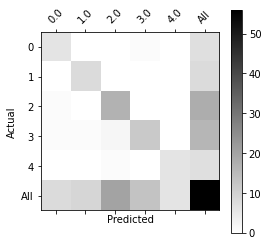

In [28]:
# START SKIP FOR GRADING
print(Y_test.shape)
print('           '+ label_to_emoji(0)+ '    ' + label_to_emoji(1) + '    ' +  label_to_emoji(2)+ '    ' + label_to_emoji(3)+'   ' + label_to_emoji(4))
print(pd.crosstab(Y_test, pred_test.reshape(56,), rownames=['Actual'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(Y_test, pred_test)
# END SKIP FOR GRADING

<font color='blue'><b>What you should remember:</b>
- Even with a mere 127 training examples, you can get a reasonably good model for Emojifying. 
    - This is due to the generalization power word vectors gives you. 
- Emojify-V1 will perform poorly on sentences such as *"This movie is not good and not enjoyable"* 
    - It doesn't understand combinations of words.
    - It just averages all the words' embedding vectors together, without considering the ordering of words. 
</font>
    
**Not to worry! You will build a better algorithm in the next section!**

<a name='2'></a>
## 2 - Emojifier-V2: Using LSTMs in Keras 

You're going to build an LSTM model that takes word **sequences** as input! This model will be able to account for word ordering. 

Emojifier-V2 will continue to use pre-trained word embeddings to represent words. You'll feed word embeddings into an LSTM, and the LSTM will learn to predict the most appropriate emoji. 

### Packages

Run the following cell to load the Keras packages you'll need:

In [37]:
import numpy as np
import tensorflow
np.random.seed(0)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.initializers import glorot_uniform
np.random.seed(1)

<a name='2-1'></a>
### 2.1 - Model Overview

Here is the Emojifier-v2 you will implement:

<img src="images/emojifier-v2.png" style="width:700px;height:400px;"> <br>
<caption><center><font color='purple'><b>Figure 3</b>: Emojifier-V2. A 2-layer LSTM sequence classifier. </center></caption>

<a name='2-2'></a>
### 2.2 Keras and Mini-batching 

In this exercise, you want to train Keras using mini-batches. However, most deep learning frameworks require that all sequences in the same mini-batch have the **same length**. 

This is what allows vectorization to work: If you had a 3-word sentence and a 4-word sentence, then the computations needed for them are different (one takes 3 steps of an LSTM, one takes 4 steps) so it's just not possible to do them both at the same time.
    
#### Padding Handles Sequences of Varying Length
* The common solution to handling sequences of **different length** is to use padding.  Specifically:
    * Set a maximum sequence length
    * Pad all sequences to have the same length. 
    
#### Example of Padding:
* Given a maximum sequence length of 20, you could pad every sentence with "0"s so that each input sentence is of length 20. 
* Thus, the sentence "I love you" would be represented as $(e_{I}, e_{love}, e_{you}, \vec{0}, \vec{0}, \ldots, \vec{0})$. 
* In this example, any sentences longer than 20 words would have to be truncated. 
* One way to choose the maximum sequence length is to just pick the length of the longest sentence in the training set. 

<a name='2-3'></a>
### 2.3 - The Embedding Layer

In Keras, the embedding matrix is represented as a "layer."

* The embedding matrix maps word indices to embedding vectors.
    * The word indices are positive integers.
    * The embedding vectors are dense vectors of fixed size.
    * A "dense" vector is the opposite of a sparse vector. It means that most of its values are non-zero.  As a counter-example, a one-hot encoded vector is not "dense."
* The embedding matrix can be derived in two ways:
    * Training a model to derive the embeddings from scratch. 
    * Using a pretrained embedding.
    
#### Using and Updating Pre-trained Embeddings
In this section, you'll create an [Embedding()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer in Keras

* You will initialize the Embedding layer with GloVe 50-dimensional vectors. 
* In the code below, you'll observe how Keras allows you to either train or leave this layer fixed.  
    * Because your training set is quite small, you'll leave the GloVe embeddings fixed instead of updating them.

#### Inputs and Outputs to the Embedding Layer

* The `Embedding()` layer's input is an integer matrix of size **(batch size, max input length)**. 
    * This input corresponds to sentences converted into lists of indices (integers).
    * The largest integer (the highest word index) in the input should be no larger than the vocabulary size.
* The embedding layer outputs an array of shape (batch size, max input length, dimension of word vectors).

* The figure shows the propagation of two example sentences through the embedding layer. 
    * Both examples have been zero-padded to a length of `max_len=5`.
    * The word embeddings are 50 units in length.
    * The final dimension of the representation is  `(2,max_len,50)`. 

<img src="images/embedding1.png" style="width:700px;height:250px;">
<caption><center><font color='purple'><b>Figure 4</b>: Embedding layer</center></caption>

#### Prepare the Input Sentences

<a name='ex-3'></a>
### Exercise 3 - sentences_to_indices

Implement `sentences_to_indices`

This function processes an array of sentences X and returns inputs to the embedding layer:

* Convert each training sentences into a list of indices (the indices correspond to each word in the sentence)
* Zero-pad all these lists so that their length is the length of the longest sentence.
    
#### Additional Hints:
* Note that you may have considered using the `enumerate()` function in the for loop, but for the purposes of passing the autograder, please follow the starter code by initializing and incrementing `j` explicitly.

In [29]:
for idx, val in enumerate(["I", "like", "learning"]):
    print(idx, val)

0 I
1 like
2 learning


In [30]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: sentences_to_indices

def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()` (described in Figure 4). 
    
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    
    m = X.shape[0]                                   # number of training examples
    
    ### START CODE HERE ###
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = np.zeros((m,max_len))
    
    for i in range(m):                               # loop over training examples
        
        # Convert the ith training sentence in lower case and split is into words. You should get a list of words.
        sentence_words = X[i].lower().split()
        
        # Initialize j to 0
        j = 0
        
        # Loop over the words of sentence_words

        for w in sentence_words:
            # if w exists in the word_to_index dictionary
            if w in word_to_index.keys():
                # Set the (i,j)th entry of X_indices to the index of the correct word.
                X_indices[i, j] = word_to_index[w]
                # Increment j to j + 1
                j =  j+1
            
    ### END CODE HERE ###
    
    return X_indices

In [31]:
# UNIT TEST
def sentences_to_indices_test(target):
    
    # Create a word_to_index dictionary
    word_to_index = {}
    for idx, val in enumerate(["i", "like", "learning", "deep", "machine", "love", "smile", '´0.=']):
        word_to_index[val] = idx;
       
    max_len = 4
    sentences = np.array(["I like deep learning", "deep ´0.= love machine", "machine learning smile"]);
    indexes = target(sentences, word_to_index, max_len)
    print(indexes)
    
    assert type(indexes) == np.ndarray, "Wrong type. Use np arrays in the function"
    assert indexes.shape == (sentences.shape[0], max_len), "Wrong shape of ouput matrix"
    assert np.allclose(indexes, [[0, 1, 3, 2],
                                 [3, 7, 5, 4],
                                 [4, 2, 6, 0]]), "Wrong values. Debug with the given examples"
    
    print("\033[92mAll tests passed!")
    
sentences_to_indices_test(sentences_to_indices)

[[0. 1. 3. 2.]
 [3. 7. 5. 4.]
 [4. 2. 6. 0.]]
All tests passed!


**Expected value**

```
[[0, 1, 3, 2],
 [3, 7, 5, 4],
 [4, 2, 6, 0]]
```

Run the following cell to check what `sentences_to_indices()` does, and take a look at your results.

In [32]:
X1 = np.array(["funny lol", "lets play baseball", "food is ready for you"])
X1_indices = sentences_to_indices(X1, word_to_index, max_len=5)
print("X1 =", X1)
print("X1_indices =\n", X1_indices)

X1 = ['funny lol' 'lets play baseball' 'food is ready for you']
X1_indices =
 [[155345. 225122.      0.      0.      0.]
 [220930. 286375.  69714.      0.      0.]
 [151204. 192973. 302254. 151349. 394475.]]


#### Build Embedding Layer

Now you'll build the `Embedding()` layer in Keras, using pre-trained word vectors. 

* The embedding layer takes as input a list of word indices.
    * `sentences_to_indices()` creates these word indices.
* The embedding layer will return the word embeddings for a sentence. 

<a name='ex-4'></a>
### Exercise 4 - pretrained_embedding_layer

Implement `pretrained_embedding_layer()` with these steps:

1. Initialize the embedding matrix as a numpy array of zeros.
    * The embedding matrix has a row for each unique word in the vocabulary.
        * There is one additional row to handle "unknown" words.
        * So vocab_size is the number of unique words plus one.
    * Each row will store the vector representation of one word. 
        * For example, one row may be 50 positions long if using GloVe word vectors.
    * In the code below, `emb_dim` represents the length of a word embedding.
2. Fill in each row of the embedding matrix with the vector representation of a word
    * Each word in `word_to_index` is a string.
    * word_to_vec_map is a dictionary where the keys are strings and the values are the word vectors.
3. Define the Keras embedding layer. 
    * Use [Embedding()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding). 
    * The input dimension is equal to the vocabulary length (number of unique words plus one).
    * The output dimension is equal to the number of positions in a word embedding.
    * Make this layer's embeddings fixed.
        * If you were to set `trainable = True`, then it will allow the optimization algorithm to modify the values of the word embeddings.
        * In this case, you don't want the model to modify the word embeddings.
4. Set the embedding weights to be equal to the embedding matrix.
    * Note that this is part of the code is already completed for you and does not need to be modified! 

In [35]:
# UNQ_C4 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: pretrained_embedding_layer

def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_size = len(word_to_index) + 1              # adding 1 to fit Keras embedding (requirement)
    any_word = list(word_to_vec_map.keys())[0]
    emb_dim = word_to_vec_map[any_word].shape[0]    # define dimensionality of your GloVe word vectors (= 50)
      
    ### START CODE HERE ###
    # Step 1
    # Initialize the embedding matrix as a numpy array of zeros.
    # See instructions above to choose the correct shape.
    emb_matrix = np.zeros((vocab_size,emb_dim))
    
    # Step 2
    # Set each row "idx" of the embedding matrix to be 
    # the word vector representation of the idx'th word of the vocabulary
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]

    # Step 3
    # Define Keras embedding layer with the correct input and output sizes
    # Make it non-trainable.
    embedding_layer =  Embedding(vocab_size, emb_dim, trainable=False)
    ### END CODE HERE ###

    # Step 4 (already done for you; please do not modify)
    # Build the embedding layer, it is required before setting the weights of the embedding layer. 
    embedding_layer.build((None,)) # Do not modify the "None".  This line of code is complete as-is.
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [38]:
# UNIT TEST
def pretrained_embedding_layer_test(target):
    # Create a controlled word to vec map
    word_to_vec_map = {'a': [3, 3], 'synonym_of_a': [3, 3], 'a_nw': [2, 4], 'a_s': [3, 2], 'a_n': [3, 4], 
                       'c': [-2, 1], 'c_n': [-2, 2],'c_ne': [-1, 2], 'c_e': [-1, 1], 'c_se': [-1, 0], 
                       'c_s': [-2, 0], 'c_sw': [-3, 0], 'c_w': [-3, 1], 'c_nw': [-3, 2]
                      }
    # Convert lists to np.arrays
    for key in word_to_vec_map.keys():
        word_to_vec_map[key] = np.array(word_to_vec_map[key])
        
    # Create a word_to_index dictionary
    word_to_index = {}
    for idx, val in enumerate(list(word_to_vec_map.keys())):
        word_to_index[val] = idx;
        
    np.random.seed(1)
    embedding_layer = target(word_to_vec_map, word_to_index)
    
    assert type(embedding_layer) == Embedding, "Wrong type"
    assert embedding_layer.input_dim == len(list(word_to_vec_map.keys())) + 1, "Wrong input shape"
    assert embedding_layer.output_dim == len(word_to_vec_map['a']), "Wrong output shape"
    assert np.allclose(embedding_layer.get_weights(), 
                       [[[ 3, 3], [ 3, 3], [ 2, 4], [ 3, 2], [ 3, 4],
                       [-2, 1], [-2, 2], [-1, 2], [-1, 1], [-1, 0],
                       [-2, 0], [-3, 0], [-3, 1], [-3, 2], [ 0, 0]]]), "Wrong vaulues"
    print("\033[92mAll tests passed!")
       
    
pretrained_embedding_layer_test(pretrained_embedding_layer)

All tests passed!


In [39]:
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
print("weights[0][1][1] =", embedding_layer.get_weights()[0][1][1])
print("Input_dim", embedding_layer.input_dim)
print("Output_dim",embedding_layer.output_dim)

weights[0][1][1] = 0.39031
Input_dim 400001
Output_dim 50


<a name='2-4'></a>
### 2.4 - Building the Emojifier-V2

Now you're ready to build the Emojifier-V2 model, in which you feed the embedding layer's output to an LSTM network!

<img src="images/emojifier-v2.png" style="width:700px;height:400px;"> <br>
<caption><center><font color='purple'><b>Figure 3</b>: Emojifier-v2. A 2-layer LSTM sequence classifier. </center></caption></font> 


<a name='ex-5'></a>
### Exercise 5 - Emojify_V2

Implement `Emojify_V2()`

This function builds a Keras graph of the architecture shown in Figure (3). 

* The model takes as input an array of sentences of shape (`m`, `max_len`, ) defined by `input_shape`. 
* The model outputs a softmax probability vector of shape (`m`, `C = 5`). 

* You may need to use the following Keras layers:
    * [Input()](https://www.tensorflow.org/api_docs/python/tf/keras/Input)
        * Set the `shape` and `dtype` parameters.
        * The inputs are integers, so you can specify the data type as a string, 'int32'.
    * [LSTM()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)
        * Set the `units` and `return_sequences` parameters.
    * [Dropout()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout)
        * Set the `rate` parameter.
    * [Dense()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)
        * Set the `units`, 
        * Note that `Dense()` has an `activation` parameter.  For the purposes of passing the autograder, please do not set the activation within `Dense()`.  Use the separate `Activation` layer to do so.
    * [Activation()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Activation)
        * You can pass in the activation of your choice as a lowercase string.
    * [Model()](https://www.tensorflow.org/api_docs/python/tf/keras/Model)
        * Set `inputs` and `outputs`.


#### Additional Hints
* Remember that these Keras layers return an object, and you will feed in the outputs of the previous layer as the input arguments to that object.  The returned object can be created and called in the same line.

```Python
# How to use Keras layers in two lines of code
dense_object = Dense(units = ...)
X = dense_object(inputs)

# How to use Keras layers in one line of code
X = Dense(units = ...)(inputs)
```

* The `embedding_layer` that is returned by `pretrained_embedding_layer` is a layer object that can be called as a function, passing in a single argument (sentence indices).

* Here is some sample code in case you're stuck: 😊
```Python
raw_inputs = Input(shape=(maxLen,), dtype='int32')
preprocessed_inputs = ... # some pre-processing
X = LSTM(units = ..., return_sequences= ...)(processed_inputs)
X = Dropout(rate = ..., )(X)
...
X = Dense(units = ...)(X)
X = Activation(...)(X)
model = Model(inputs=..., outputs=...)
...
```

In [49]:
# UNQ_C5 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: Emojify_V2

def Emojify_V2(input_shape, word_to_vec_map, word_to_index):
    """
    Function creating the Emojify-v2 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    ### START CODE HERE ###
    # Define sentence_indices as the input of the graph.
    # It should be of shape input_shape and dtype 'int32' (as it contains indices, which are integers).
    sentence_indices = Input(shape=input_shape, dtype='int32')
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagate sentence_indices through your embedding layer
    # (See additional hints in the instructions).
    embeddings = embedding_layer(sentence_indices)   
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # The returned output should be a batch of sequences.
    X = LSTM(units = 128, return_sequences=True)(embeddings)
    # Add dropout with a probability of 0.5
    X =  Dropout(rate = 0.5 )(X) 
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # The returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(units =128, return_sequences=False)(X)
    # Add dropout with a probability of 0.5
    X = Dropout(rate = 0.5 )(X)  
    # Propagate X through a Dense layer with 5 units
    X = Dense(units = 5)(X)
    # Add a softmax activation
    X = Activation('softmax')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=sentence_indices, outputs=X)
    
    ### END CODE HERE ###
    
    return model

In [50]:
# UNIT TEST
def Emojify_V2_test(target):
    # Create a controlled word to vec map
    word_to_vec_map = {'a': [3, 3], 'synonym_of_a': [3, 3], 'a_nw': [2, 4], 'a_s': [3, 2], 'a_n': [3, 4], 
                       'c': [-2, 1], 'c_n': [-2, 2],'c_ne': [-1, 2], 'c_e': [-1, 1], 'c_se': [-1, 0], 
                       'c_s': [-2, 0], 'c_sw': [-3, 0], 'c_w': [-3, 1], 'c_nw': [-3, 2]
                      }
    # Convert lists to np.arrays
    for key in word_to_vec_map.keys():
        word_to_vec_map[key] = np.array(word_to_vec_map[key])
        
    # Create a word_to_index dictionary
    word_to_index = {}
    for idx, val in enumerate(list(word_to_vec_map.keys())):
        word_to_index[val] = idx;
        
    maxLen = 4
    model = target((maxLen,), word_to_vec_map, word_to_index)
    
    expectedModel = [['InputLayer', [(None, 4)], 0], ['Embedding', (None, 4, 2), 30], ['LSTM', (None, 4, 128), 67072, (None, 4, 2), 'tanh', True], ['Dropout', (None, 4, 128), 0, 0.5], ['LSTM', (None, 128), 131584, (None, 4, 128), 'tanh', False], ['Dropout', (None, 128), 0, 0.5], ['Dense', (None, 5), 645, 'linear'], ['Activation', (None, 5), 0]]
    comparator(summary(model), expectedModel)
    
    
Emojify_V2_test(Emojify_V2)

All tests passed!


Run the following cell to create your model and check its summary. 

* Because all sentences in the dataset are less than 10 words, `max_len = 10` was chosen.  
* You should see that your architecture uses 20,223,927 parameters, of which 20,000,050 (the word embeddings) are non-trainable, with the remaining 223,877 being trainable. 
* Because your vocabulary size has 400,001 words (with valid indices from 0 to 400,000) there are 400,001\*50 = 20,000,050 non-trainable parameters. 

In [51]:
model = Emojify_V2((maxLen,), word_to_vec_map, word_to_index)
model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 10, 50)            20000050  
_________________________________________________________________
lstm_9 (LSTM)                (None, 10, 128)           91648     
_________________________________________________________________
dropout_11 (Dropout)         (None, 10, 128)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 5)                

#### Compile the Model 

As usual, after creating your model in Keras, you need to compile it and define what loss, optimizer and metrics you want to use. Compile your model using `categorical_crossentropy` loss, `adam` optimizer and `['accuracy']` metrics:

In [52]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

<a name='2-5'></a>
### 2.5 - Train the Model 

It's time to train your model! Your Emojifier-V2 `model` takes as input an array of shape (`m`, `max_len`) and outputs probability vectors of shape (`m`, `number of classes`). Thus, you have to convert X_train (array of sentences as strings) to X_train_indices (array of sentences as list of word indices), and Y_train (labels as indices) to Y_train_oh (labels as one-hot vectors).

In [53]:
X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
Y_train_oh = convert_to_one_hot(Y_train, C = 5)

Fit the Keras model on `X_train_indices` and `Y_train_oh`, using `epochs = 50` and `batch_size = 32`.

In [54]:
model.fit(X_train_indices, Y_train_oh, epochs = 50, batch_size = 32, shuffle=True)

Epoch 1/50
5/5 [==============================] - 0s 22ms/step - loss: 1.5823 - accuracy: 0.2803
Epoch 2/50
5/5 [==============================] - 0s 25ms/step - loss: 1.5201 - accuracy: 0.3030
Epoch 3/50
5/5 [==============================] - 0s 22ms/step - loss: 1.4686 - accuracy: 0.3485
Epoch 4/50
5/5 [==============================] - 0s 21ms/step - loss: 1.3826 - accuracy: 0.4394
Epoch 5/50
5/5 [==============================] - 0s 22ms/step - loss: 1.3334 - accuracy: 0.5530
Epoch 6/50
5/5 [==============================] - 0s 20ms/step - loss: 1.2407 - accuracy: 0.4848
Epoch 7/50
5/5 [==============================] - 0s 21ms/step - loss: 1.1367 - accuracy: 0.5758
Epoch 8/50
5/5 [==============================] - 0s 20ms/step - loss: 0.9966 - accuracy: 0.6591
Epoch 9/50
5/5 [==============================] - 0s 20ms/step - loss: 0.8915 - accuracy: 0.6742
Epoch 10/50
5/5 [==============================] - 0s 22ms/step - loss: 0.7603 - accuracy: 0.7879
Epoch 11/50
5/5 [============

Your model should perform around **90% to 100% accuracy** on the training set. Exact model accuracy may vary! 

Run the following cell to evaluate your model on the test set: 

In [55]:
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len = maxLen)
Y_test_oh = convert_to_one_hot(Y_test, C = 5)
loss, acc = model.evaluate(X_test_indices, Y_test_oh)
print()
print("Test accuracy = ", acc)

2/2 [==============================] - 0s 2ms/step - loss: 0.5670 - accuracy: 0.8036

Test accuracy =  0.8035714030265808


You should get a test accuracy between 80% and 95%. Run the cell below to see the mislabelled examples: 

In [56]:
# This code allows you to see the mislabelled examples
C = 5
y_test_oh = np.eye(C)[Y_test.reshape(-1)]
X_test_indices = sentences_to_indices(X_test, word_to_index, maxLen)
pred = model.predict(X_test_indices)
for i in range(len(X_test)):
    x = X_test_indices
    num = np.argmax(pred[i])
    if(num != Y_test[i]):
        print('Expected emoji:'+ label_to_emoji(Y_test[i]) + ' prediction: '+ X_test[i] + label_to_emoji(num).strip())

Expected emoji:😄 prediction: she got me a nice present	❤️
Expected emoji:😞 prediction: This girl is messing with me	❤️
Expected emoji:😞 prediction: stop pissing me off⚾
Expected emoji:🍴 prediction: any suggestions for dinner	😄
Expected emoji:😄 prediction: you brighten my day	❤️
Expected emoji:😄 prediction: will you be my valentine	😞
Expected emoji:🍴 prediction: See you at the restaurant	⚾
Expected emoji:😄 prediction: What you did was awesome	😞
Expected emoji:😞 prediction: go away	⚾
Expected emoji:😞 prediction: yesterday we lost again	⚾
Expected emoji:❤️ prediction: family is all I have	😞


Now you can try it on your own example! Write your own sentence below:

In [57]:
# Change the sentence below to see your prediction. Make sure all the words are in the Glove embeddings.  
x_test = np.array(['I cannot play'])
X_test_indices = sentences_to_indices(x_test, word_to_index, maxLen)
print(x_test[0] +' '+  label_to_emoji(np.argmax(model.predict(X_test_indices))))

I cannot play ⚾


#### LSTM Version Accounts for Word Order
* The Emojify-V1 model did not "not feeling happy" correctly, but your implementation of Emojify-V2 got it right! 
    * If it didn't, be aware that Keras' outputs are slightly random each time, so this is probably why. 
* The current model still isn't very robust at understanding negation (such as "not happy")
    * This is because the training set is small and doesn't have a lot of examples of negation. 
    * If the training set were larger, the LSTM model would be much better than the Emojify-V1 model at understanding more complex sentences. 

### Congratulations!
 
You've completed this notebook, and harnessed the power of LSTMs to make your words more emotive! ❤️❤️❤️

By now, you've: 

* Created an embedding matrix
* Observed how negative sampling learns word vectors more efficiently than other methods
* Experienced the advantages and disadvantages of the GloVe algorithm
* And built a sentiment classifier using word embeddings! 

Cool! (or Emojified: 😎😎😎 ) 

<font color='blue'><b>What you should remember</b>:
- If you have an NLP task where the training set is small, using word embeddings can help your algorithm significantly. 
- Word embeddings allow your model to work on words in the test set that may not even appear in the training set. 
- Training sequence models in Keras (and in most other deep learning frameworks) requires a few important details:
    - To use mini-batches, the sequences need to be **padded** so that all the examples in a mini-batch have the **same length**. 
    - An `Embedding()` layer can be initialized with pretrained values. 
        - These values can be either fixed or trained further on your dataset. 
        - If however your labeled dataset is small, it's usually not worth trying to train a large pre-trained set of embeddings.   
    - `LSTM()` has a flag called `return_sequences` to decide if you would like to return every hidden states or only the last one. 
    - You can use `Dropout()` right after `LSTM()` to regularize your network. 


### Input sentences:
```Python
"Congratulations on finishing this assignment and building an Emojifier."
"We hope you're happy with what you've accomplished in this notebook!"
```
### Output emojis:
# 😀😀😀😀😀😀

☁ 👋🚀 ☁☁

      ✨ BYE-BYE!
      
☁ ✨  🎈

      ✨  ☁
  
         ✨
 
     ✨
 
🌾✨💨 🏃 🏠🏢                    

<a name='3'></a>
## 3 - Acknowledgments

Thanks to Alison Darcy and the Woebot team for their advice on the creation of this assignment. 
* Woebot is a chatbot friend that is ready to speak with you 24/7. 
* Part of Woebot's technology uses word embeddings to understand the emotions of what you say. 
* You can chat with Woebot by going to http://woebot.io

<img src="images/woebot.png" style="width:600px;height:300px;">